# Variable Boundary Conditions with Φ<sub>Flow</sub>

[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tum-pbs/PhiFlow/blob/develop/examples/grids/Variable_Boundaries.ipynb)

This notebook demonstrates the use of variable boundary conditions, i.e. specifying different boundaries per side and spatially-varying boundary conditions.

Execute the cell below to install the [Φ<sub>Flow</sub> Python package from GitHub](https://github.com/tum-pbs/PhiFlow).

In [2]:
%pip install phiflow
from phi.flow import *

## Spatially-varying Boundary

Here, we want to specify a gradual inflow / outflow for the left boundary of our 2D domain, i.e. the `x-` side.
To do this, we define a field, `inflow`, that will serve as the boundary condition for `x-`.

In [3]:
domain = Box(x=10, y=10)
inflow = CenteredGrid(lambda x, y: vec(x=math.tanh((y-5)/2), y=0), ZERO_GRADIENT, domain, x=1, y=32)

We use `ZERO_GRADIENT` to make sure this inflow applies to all `x` values, not just at the domain center, x=5, where it is defined.
Let's plot this boundary condition.

<Figure size 216x288 with 1 Axes>

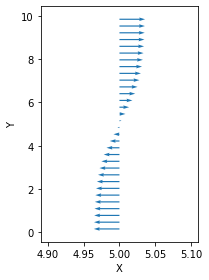

In [4]:
plot(inflow.as_points(), size=(3, 4))

Next, we define the full domain boundary. When using a `Field` as a Dirichlet boundary condition, we need to convert it using `as_boundary()`. For the right side, we use free flow (Neumann) and for the top and bottom, we set velocity=0.

In [5]:
boundary = {'x-': inflow.as_boundary(), 'x+': ZERO_GRADIENT, 'y': 0}

Let's visualize the boundary on an example grid, initialized using noise.

c:\ProgramData\Anaconda3\envs\phiflow2\lib\site-packages\phiml\backend\_backend.py:1632: RuntimeWarning: invalid value encountered in power
  return base ** exp


<Figure size 864x360 with 2 Axes>

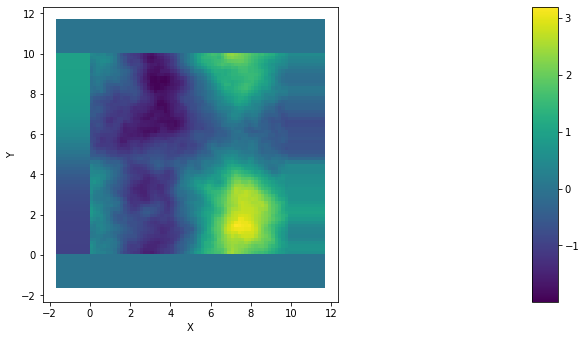

In [6]:
plot(CenteredGrid(Noise(vector='x,y'), boundary, domain, x=60, y=60).pad(10)['x'])

As expected, the top and bottom values are 0 while the left side is given by our inflow condition and the right side is given by the edge velocities.

Note that our boundary can be applied to fields of any resolution. It will be interpolated automatically as needed, as shown here.

## Fluid Simulation

Now, let's run an incompressible Navier-Stokes simulation for these boundary conditions.
We define a basic operator splitting method in the next cell and perform one step.
We now use the same resolution we defined for our boundary to avoid unnecessary interpolations.

<Figure size 864x360 with 3 Axes>

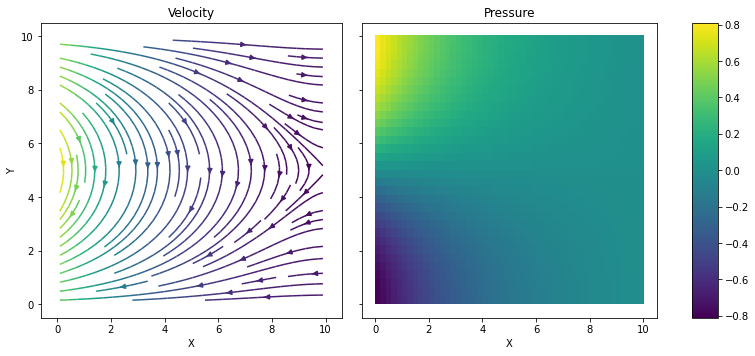

In [8]:
def step(v: Field, pressure, dt=1.):  # velocity, pressure, time increment
    v = advect.semi_lagrangian(v, v, dt)
    v = diffuse.explicit(v, 0.01, dt)
    v, pressure = fluid.make_incompressible(v, solve=Solve(x0=pressure))
    return v, pressure


v0 = StaggeredGrid(0, boundary, domain, x=50, y=32)
v, p = step(v0, None)
plot({'velocity': v, 'pressure': p})